# IRAM Data Example

Trey V. Wenger (c) March 2025

Here we test `bayes_cn_hfs` on some real IRAM 30-m data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.4
bayes_cn_hfs version: 1.1.1+6.g94944ab.dirty


## Load the data

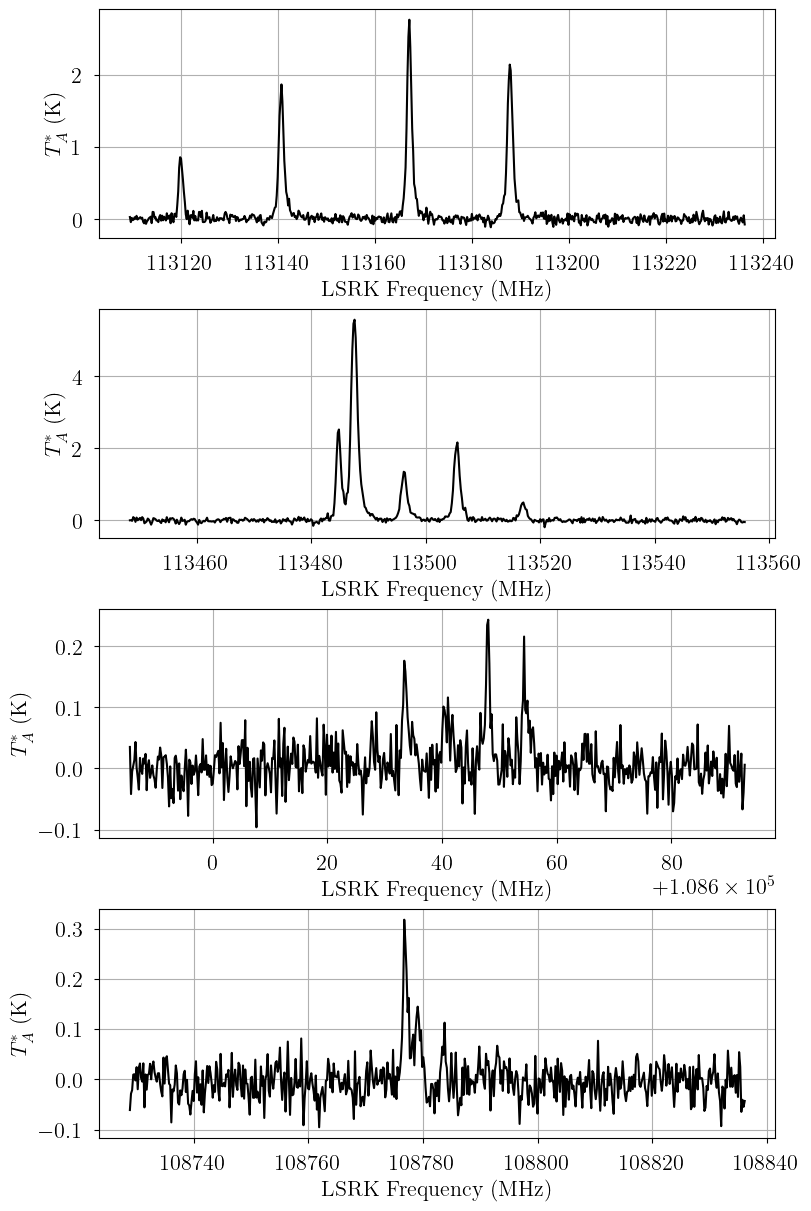

In [2]:
from bayes_spec import SpecData
import pickle

with open("iram_data.pkl", "rb") as f:
    iram_data = pickle.load(f)

labels = ["12CN-1/2", "12CN-3/2", "13CN-1/2", "13CN-3/2"]
data = {
    label: SpecData(
        iram_data[f"frequency_{label}"][500:-500],
        iram_data[f"spectrum_{label}"][500:-500],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels
}

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in labels if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, label in enumerate(labels):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Inspecting the CN data

We don't assume LTE, but we fix the kinetic temperature.

In [3]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
baseline_degree = 0
n_clouds = 2
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = None, # ignored because kinetic temperature is fixed
    prior_velocity = [10.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.25], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1/2, 12CN-3/2, LTE_precision, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


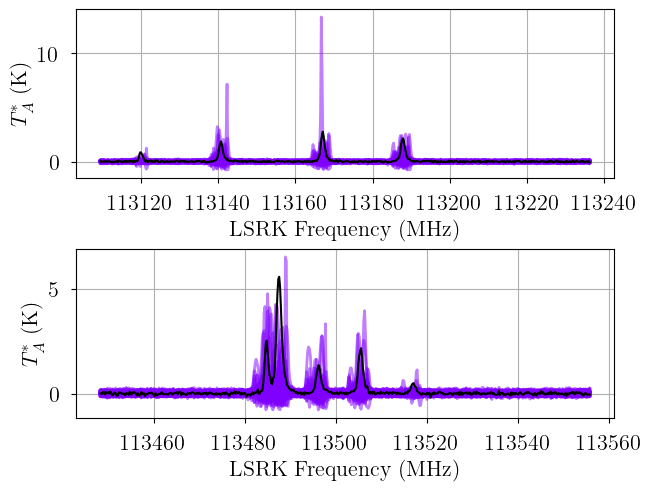

In [4]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [5]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 3.9785e+05


Output()

Runtime: 0.53 minutes


Sampling: [12CN-1/2, 12CN-3/2]


Output()

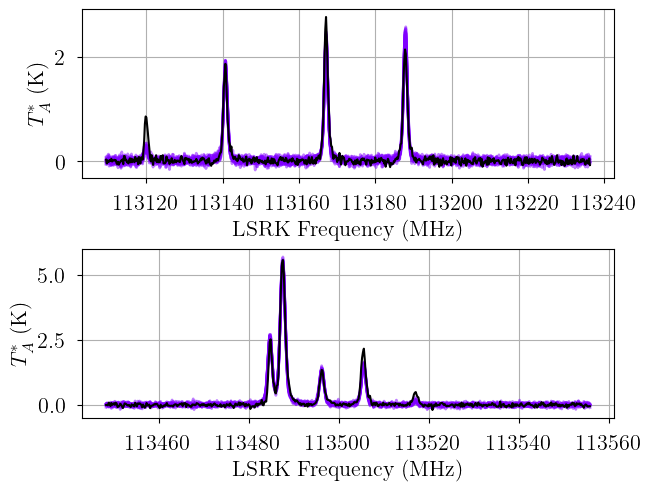

In [6]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [7]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean       sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1/2_norm[0]  -0.100    0.042   -0.181   -0.023      0.001   
baseline_12CN-3/2_norm[0]  -0.231    0.049   -0.321   -0.141      0.002   
velocity_norm[0]           -0.301    0.002   -0.306   -0.297      0.000   
velocity_norm[1]           -0.292    0.002   -0.297   -0.288      0.000   
log10_N_norm[0]             1.093    0.003    1.087    1.100      0.000   
log10_N_norm[1]             0.125    0.002    0.120    0.129      0.000   
log10_Tex_ul_norm[0]        1.562    0.566    0.561    2.701      0.018   
log10_Tex_ul_norm[1]        1.717    0.737    0.287    3.093      0.024   
fwhm_nonthermal_norm[0]     2.800    0.017    2.768    2.830      0.001   
fwhm_nonthermal_norm[1]     2.672    0.013    2.647    2.696      0.000   
fwhm_L_norm                 1.049    0.020    1.013    1.086      0.001   
LTE_precision[0]            0.029    0.011    0.013    0.051      0.000   
LTE_precision[1]            0.183    0.033    0.124    0.240      0.001   
weights[0, 0 0 1 1]         0.066    0.001    0.064    0.067      0.000   
weights[0, 0 0 1 2]         0.251    0.001    0.249    0.252      0.000   
weights[0, 1 0 1 1]         0.108    0.001    0.107    0.110      0.000   
weights[0, 1 0 1 2]         0.225    0.001    0.222    0.227      0.000   
weights[0, 1 0 2 1]         0.073    0.001    0.071    0.074      0.000   
weights[0, 1 0 2 2]         0.191    0.001    0.189    0.193      0.000   
weights[0, 1 0 2 3]         0.087    0.002    0.084    0.090      0.000   
weights[1, 0 0 1 1]         0.002    0.002    0.000    0.004      0.000   
weights[1, 0 0 1 2]         0.002    0.002    0.000    0.005      0.000   
weights[1, 1 0 1 1]         0.001    0.001    0.000    0.001      0.000   
weights[1, 1 0 1 2]         0.002    0.002    0.000    0.005      0.000   
weights[1, 1 0 2 1]         0.000    0.000    0.000    0.001      0.000   
weights[1, 1 0 2 2]         0.001    0.001    0.000    0.003      0.000   
weights[1, 1 0 2 3]         0.992    0.007    0.981    0.999      0.000   
velocity[0]                 9.096    0.007    9.081    9.108      0.000   
velocity[1]                 9.124    0.007    9.110    9.137      0.000   
fwhm_thermal[0]             0.236    0.000    0.236    0.236      0.000   
fwhm_thermal[1]             0.236    0.000    0.236    0.236      0.000   
fwhm_nonthermal[0]          2.800    0.017    2.768    2.830      0.001   
fwhm_nonthermal[1]          2.672    0.013    2.647    2.696      0.000   
fwhm[0]                     2.810    0.017    2.778    2.840      0.001   
fwhm[1]                     2.683    0.013    2.658    2.706      0.000   
fwhm_L                      1.049    0.020    1.013    1.086      0.001   
log10_N[0]                 14.297    0.002   14.294   14.300      0.000   
log10_N[1]                 13.812    0.001   13.810   13.815      0.000   
log10_Tex_ul[0]             0.891    0.141    0.640    1.175      0.005   
log10_Tex_ul[1]             0.929    0.184    0.572    1.273      0.006   
Tex[113123.3687, 0]       -10.977    0.311  -11.570  -10.440      0.011   
Tex[113123.3687, 1]         8.115   30.808    2.588   13.545      1.020   
Tex[113144.19, 0]          36.381    1.999   32.712   40.100      0.068   
Tex[113144.19, 1]           6.306  226.509  -22.581   49.784      8.049   
Tex[113170.535, 0]        -10.162    0.250  -10.594   -9.671      0.009   
Tex[113170.535, 1]         24.218  516.506 -119.770  114.247     16.301   
Tex[113191.325, 0]         49.613    2.891   44.436   55.135      0.099   
Tex[113191.325, 1]         -8.991  380.211 -212.546  221.557     12.362   
Tex[113488.142, 0]        -14.592    0.540  -15.555  -13.523      0.019   
Tex[113488.142, 1]          7.040   28.308    2.408   17.128      0.906   
Tex[113490.985, 0]          3.719    0.052    3.623    3.815      0.002   
Tex[113490.985, 1]         -0.907    0.118   -1.127   -0.713      0.004   
Tex[113499.643, 0]        -56.139    9.493  -73.371  -

In [8]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 3.9785e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 288 tune and 0 draw iterations (2_304 + 0 draws total) took 339 seconds.


Adding log-likelihood to trace


KeyError: 'posterior'

In [ ]:
model.solve()

Sampling: [12CN-1/2, 12CN-3/2]


Output()

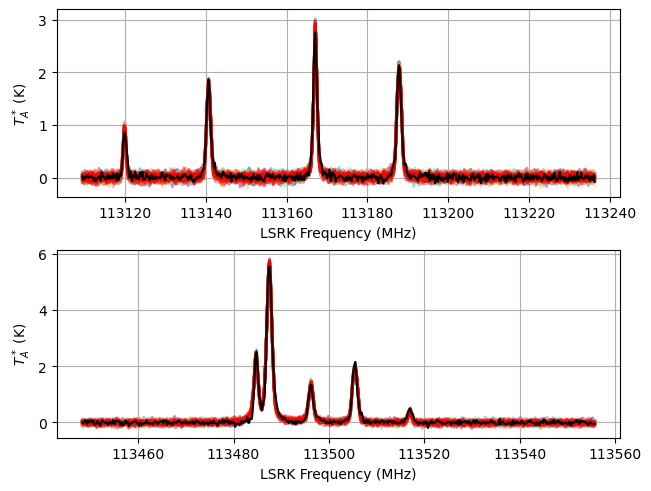

In [41]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [42]:
pm.summary(model.trace.solution_0)

/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean          sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1/2_norm[0]    -0.214       0.041   -0.292   -0.138      0.000   
baseline_12CN-3/2_norm[0]    -0.448       0.047   -0.534   -0.356      0.000   
velocity_norm[0]             -0.277       0.003   -0.282   -0.272      0.000   
velocity_norm[1]             -0.293       0.002   -0.297   -0.289      0.000   
log10_N_norm[0]               1.307       0.057    1.204    1.416      0.001   
log10_N_norm[1]               2.917       0.060    2.808    3.035      0.001   
log10_Tex_ul_norm[0]          1.147       0.588    0.062    2.209      0.006   
log10_Tex_ul_norm[1]          1.586       0.619    0.482    2.783      0.007   
fwhm_nonthermal_norm[0]       2.863       0.066    2.742    2.988      0.001   
fwhm_nonthermal_norm[1]       2.131       0.046    2.043    2.212      0.001   
fwhm_L_norm                   0.411       0.027    0.361    0.463      0.000   
LTE_precision[0]              0.061       0.017    0.031    0.094      0.000   
LTE_precision[1]              0.057       0.017    0.028    0.090      0.000   
weights[0, 0 0 1 1]           0.547       0.030    0.491    0.604      0.001   
weights[0, 0 0 1 2]           0.069       0.018    0.035    0.104      0.000   
weights[0, 1 0 1 1]           0.051       0.002    0.047    0.054      0.000   
weights[0, 1 0 1 2]           0.079       0.003    0.073    0.085      0.000   
weights[0, 1 0 2 1]           0.028       0.007    0.014    0.042      0.000   
weights[0, 1 0 2 2]           0.094       0.003    0.088    0.100      0.000   
weights[0, 1 0 2 3]           0.132       0.009    0.116    0.148      0.000   
weights[1, 0 0 1 1]           0.005       0.003    0.000    0.011      0.000   
weights[1, 0 0 1 2]           0.482       0.009    0.464    0.499      0.000   
weights[1, 1 0 1 1]           0.043       0.002    0.039    0.047      0.000   
weights[1, 1 0 1 2]           0.113       0.002    0.109    0.118      0.000   
weights[1, 1 0 2 1]           0.047       0.002    0.044    0.051      0.000   
weights[1, 1 0 2 2]           0.110       0.002    0.105    0.114      0.000   
weights[1, 1 0 2 3]           0.200       0.005    0.190    0.210      0.000   
velocity[0]                   9.170       0.008    9.155    9.185      0.000   
velocity[1]                   9.121       0.007    9.108    9.133      0.000   
fwhm_thermal[0]               0.236       0.000    0.236    0.236      0.000   
fwhm_thermal[1]               0.236       0.000    0.236    0.236      0.000   
fwhm_nonthermal[0]            2.863       0.066    2.742    2.988      0.001   
fwhm_nonthermal[1]            2.131       0.046    2.043    2.212      0.001   
fwhm[0]                       2.873       0.066    2.752    2.997      0.001   
fwhm[1]                       2.144       0.045    2.057    2.224      0.001   
fwhm_L                        0.411       0.027    0.361    0.463      0.000   
log10_N[0]                   14.404       0.028   14.352   14.458      0.000   
log10_N[1]                   15.208       0.030   15.154   15.267      0.001   
log10_Tex_ul[0]               0.787       0.147    0.515    1.052      0.002   
log10_Tex_ul[1]               0.897       0.155    0.620    1.196      0.002   
Tex[113123.3687, 0]           2.282       0.061    2.170    2.402      0.001   
Tex[113123.3687, 1]          -2.533       0.808   -4.027   -1.110      0.018   
Tex[113144.19, 0]           -21.283     443.856 -117.703   54.352      4.934   
Tex[113144.19, 1]             3.165       0.116    2.959    3.394      0.002   
Tex[113170.535, 0]            2.073       0.069    1.937    2.198      0.001   
Tex[113170.535, 1]           -2.224       0.606   -3.415   -1.142      0.014   
Tex[113191.325, 0]          -18.642    2980.761 -294.368  292.777     33.276   
Tex[113191.325, 1]            3.750       0.099    3.569    3.941      0.002   
Tex[113488.142, 0]            2.221       0.069    2.084    2.344      0.001   
Tex[113488.142, 1]           -2

## Number of cloud components

In [43]:
from bayes_spec import Optimize
from bayes_cn_hfs.cn_model import CNModel

max_n_clouds = 6
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N = [14.0, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = None, # ignored because kinetic temperature is fixed
    prior_velocity = [9.0, 2.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.75, 0.25], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 10.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Sampling: [12CN-1/2, 12CN-3/2, LTE_precision, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


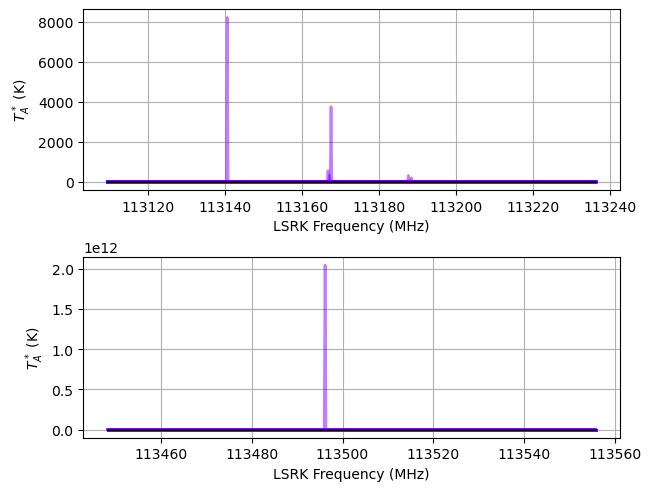

In [44]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

In [45]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 3.2686e+07


Output()

n_cloud = 1 BIC = -1.340e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 10300
Interrupted at 10,299 [10%]: Average Loss = 4.8021e+05


Output()

n_cloud = 2 BIC = -2.145e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 15100
Interrupted at 15,099 [15%]: Average Loss = 1.2145e+11


Output()

n_cloud = 3 BIC = -2.557e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 16500
Interrupted at 16,499 [16%]: Average Loss = 2.9006e+23


Output()

n_cloud = 4 BIC = -2.847e+03

Approximating n_cloud = 5 posterior...


Output()

Finished [100%]: Average Loss = -1,622.7


Output()

n_cloud = 5 BIC = -2.969e+03

Approximating n_cloud = 6 posterior...


Output()

Finished [100%]: Average Loss = 32,567


Output()

n_cloud = 6 BIC = 1.272e+04

Runtime: 37.99 minutes


[95704.84851857 -1340.21561765 -2144.69137606 -2556.79232979
 -2847.38402544 -2969.2949309  12723.96964373]


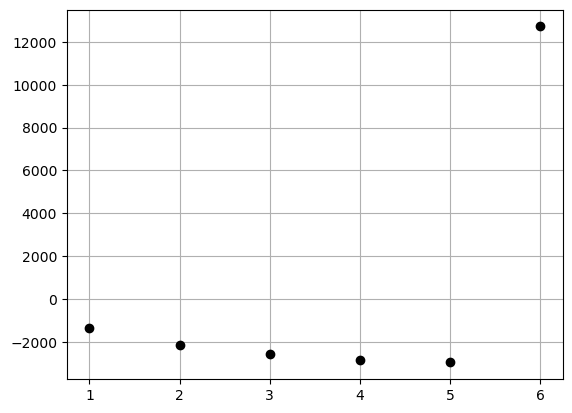

In [46]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')

In [47]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 100_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 3.2686e+07
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 189 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -1.652e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10300
Interrupted at 10,299 [10%]: Average Loss = 4.8021e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 7286 seconds.


Adding log-likelihood to trace


Output()

There were 238 divergences in converged chains.
GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -2.857e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 15100
Interrupted at 15,099 [15%]: Average Loss = 1.2145e+11
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 10639 seconds.


Adding log-likelihood to trace


Output()

There were 189 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 16500
Interrupted at 16,499 [16%]: Average Loss = 2.9006e+23
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 12034 seconds.


Adding log-likelihood to trace


Output()

There were 2346 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = -1,622.7
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 14879 seconds.


Adding log-likelihood to trace


Output()

There were 1388 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 6 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = 32,567
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 16971 seconds.


Adding log-likelihood to trace


Output()

There were 1200 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Runtime: 1072.22 minutes


No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
[95704.84851857 -1651.6711028  -2856.64730192            inf
            inf            inf            inf]


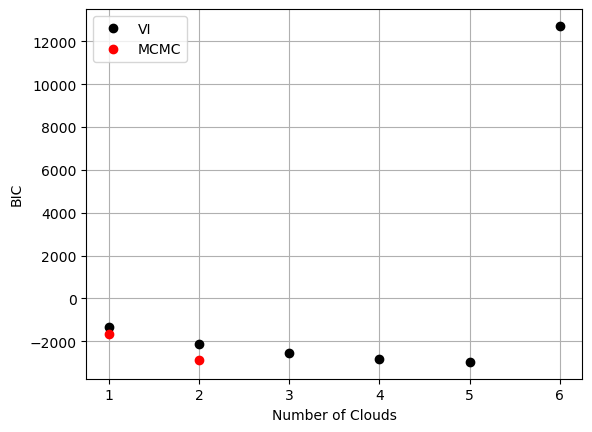

In [48]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_mcmc = np.array([null_bic] + [model.bic() for model in opt.models.values()])
print(bics_mcmc)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
plt.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
plt.xlabel("Number of Clouds")
plt.ylabel("BIC")
_ = plt.legend()

In [49]:
model = opt.models[2]
print(model.n_clouds)
pm.summary(model.trace.solution_0)

2


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean        sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1/2_norm[0]  -0.214     0.042   -0.293   -0.136      0.001   
baseline_12CN-3/2_norm[0]  -0.442     0.049   -0.531   -0.349      0.001   
velocity_norm[0]            0.085     0.004    0.078    0.093      0.000   
velocity_norm[1]            0.061     0.003    0.054    0.067      0.000   
log10_N_norm[0]             0.770     0.063    0.653    0.885      0.002   
log10_N_norm[1]             2.429     0.061    2.318    2.549      0.001   
log10_Tex_ul_norm[0]        0.600     0.742   -0.727    2.028      0.009   
log10_Tex_ul_norm[1]        0.867     0.747   -0.451    2.328      0.009   
fwhm_nonthermal_norm[0]     2.900     0.073    2.763    3.036      0.002   
fwhm_nonthermal_norm[1]     2.179     0.049    2.084    2.266      0.001   
fwhm_L_norm                 0.405     0.028    0.351    0.456      0.001   
LTE_precision[0]            0.164     0.074    0.051    0.296      0.001   
LTE_precision[1]            0.155     0.074    0.047    0.292      0.001   
weights[0, 0 0 1 1]         0.585     0.035    0.520    0.651      0.001   
weights[0, 0 0 1 2]         0.047     0.022    0.004    0.083      0.001   
weights[0, 1 0 1 1]         0.050     0.002    0.047    0.053      0.000   
weights[0, 1 0 1 2]         0.077     0.003    0.070    0.083      0.000   
weights[0, 1 0 2 1]         0.027     0.008    0.012    0.042      0.000   
weights[0, 1 0 2 2]         0.093     0.004    0.086    0.099      0.000   
weights[0, 1 0 2 3]         0.121     0.010    0.104    0.140      0.000   
weights[1, 0 0 1 1]         0.002     0.002    0.000    0.007      0.000   
weights[1, 0 0 1 2]         0.484     0.010    0.465    0.503      0.000   
weights[1, 1 0 1 1]         0.043     0.002    0.039    0.047      0.000   
weights[1, 1 0 1 2]         0.112     0.002    0.108    0.117      0.000   
weights[1, 1 0 2 1]         0.047     0.002    0.043    0.051      0.000   
weights[1, 1 0 2 2]         0.109     0.002    0.104    0.113      0.000   
weights[1, 1 0 2 3]         0.203     0.005    0.192    0.212      0.000   
velocity[0]                 9.171     0.008    9.156    9.186      0.000   
velocity[1]                 9.121     0.007    9.109    9.133      0.000   
fwhm_thermal[0]             0.236     0.000    0.236    0.236      0.000   
fwhm_thermal[1]             0.236     0.000    0.236    0.236      0.000   
fwhm_nonthermal[0]          2.900     0.073    2.763    3.036      0.002   
fwhm_nonthermal[1]          2.179     0.049    2.084    2.266      0.001   
fwhm[0]                     2.910     0.073    2.773    3.046      0.002   
fwhm[1]                     2.192     0.048    2.098    2.278      0.001   
fwhm_L                      0.405     0.028    0.351    0.456      0.001   
log10_N[0]                 14.385     0.032   14.326   14.443      0.001   
log10_N[1]                 15.215     0.031   15.159   15.275      0.001   
log10_Tex_ul[0]             0.900     0.185    0.568    1.257      0.002   
log10_Tex_ul[1]             0.967     0.187    0.637    1.332      0.002   
Tex[113123.3687, 0]         2.212     0.062    2.100    2.333      0.001   
Tex[113123.3687, 1]        -1.762     0.703   -3.109   -0.611      0.017   
Tex[113144.19, 0]          -8.922   200.906  -28.052   -1.213      2.256   
Tex[113144.19, 1]           3.151     0.120    2.940    3.390      0.002   
Tex[113170.535, 0]          1.996     0.072    1.863    2.131      0.002   
Tex[113170.535, 1]         -1.601     0.574   -2.679   -0.593      0.015   
Tex[113191.325, 0]        -21.783   725.185 -126.477   88.800      8.263   
Tex[113191.325, 1]          3.723     0.104    3.530    3.921      0.002   
Tex[113488.142, 0]          2.153     0.071    2.026    2.292      0.002   
Tex[113488.142, 1]         -1.623     0.585   -2.738   -0.611      0.015   
Tex[113490.985, 0]        -17.348   279.828  -50.740   -1.236      2.920   
Tex[113490.985, 1]          4.277     0.145    4.020    4.564      0.002   
T

Sampling: [12CN-1/2, 12CN-3/2]


Output()

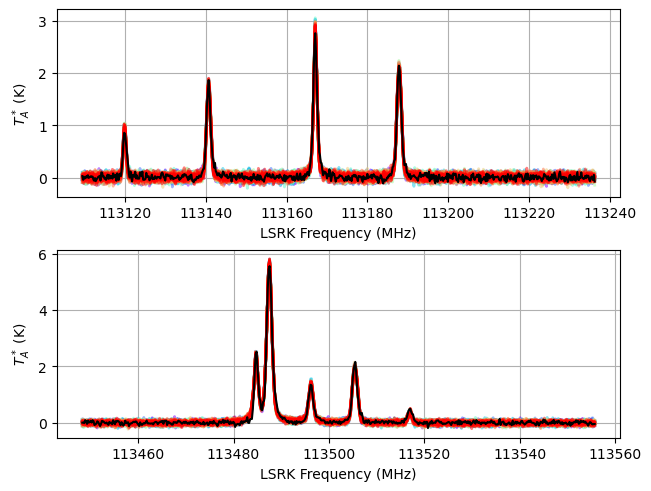

In [50]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Ratio Model
We start by assuming CTEX for 13CN.

In [54]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.5, 0.5], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [9.0, 2.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.6, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1/2, 12CN-3/2, 13CN-1/2, 13CN-3/2, LTE_precision, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, baseline_13CN-1/2_norm, baseline_13CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN]


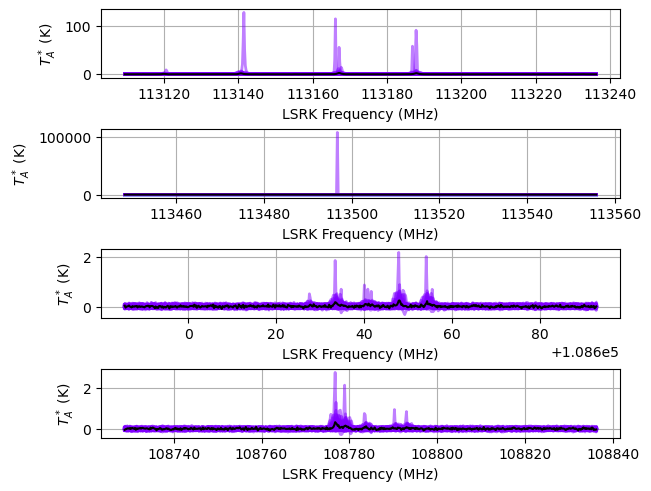

In [55]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [56]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7600
Interrupted at 7,599 [7%]: Average Loss = 4.8595e+39


Output()

Runtime: 3.14 minutes


Sampling: [12CN-1/2, 12CN-3/2, 13CN-1/2, 13CN-3/2]


Output()

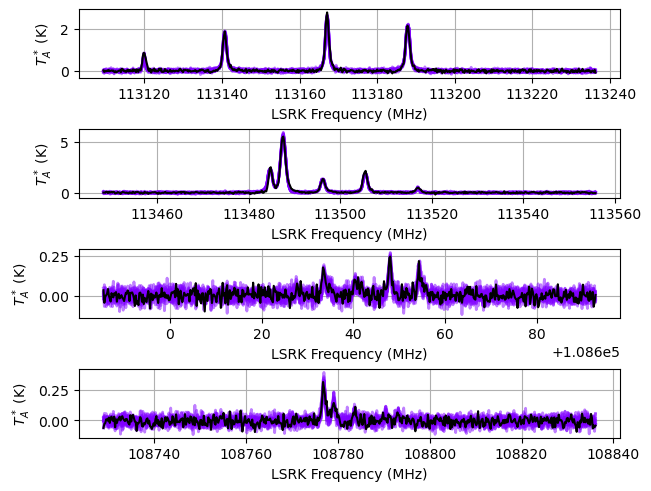

In [57]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [58]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7600
Interrupted at 7,599 [7%]: Average Loss = 4.8595e+39
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, baseline_13CN-1/2_norm, baseline_13CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 20528 seconds.


Adding log-likelihood to trace


Output()

Runtime: 346.35 minutes


In [59]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [60]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1/2_norm[0] -2.150000e-01  4.200000e-02 -2.940000e-01   
baseline_12CN-3/2_norm[0] -4.470000e-01  4.800000e-02 -5.380000e-01   
baseline_13CN-1/2_norm[0] -8.300000e-02  4.400000e-02 -1.650000e-01   
baseline_13CN-3/2_norm[0] -1.330000e-01  4.400000e-02 -2.160000e-01   
velocity_norm[0]           8.500000e-02  4.000000e-03  7.800000e-02   
velocity_norm[1]           6.000000e-02  3.000000e-03  5.400000e-02   
log10_N_12CN_norm[0]      -1.880000e-01  5.600000e-02 -2.950000e-01   
log10_N_12CN_norm[1]       1.423000e+00  6.100000e-02  1.312000e+00   
log10_Tex_ul_norm[0]       1.007000e+00  6.950000e-01 -2.840000e-01   
log10_Tex_ul_norm[1]       9.320000e-01  6.680000e-01 -2.770000e-01   
fwhm_nonthermal_norm[0]    2.883000e+00  6.600000e-02  2.754000e+00   
fwhm_nonthermal_norm[1]    2.139000e+00  4.500000e-02  2.060000e+00   
fwhm_L_norm                4.120000e-01  2.800000e-02  3.600000e-01   
ratio_12C_13C[0]           3.587900e+01  1.919500e+01  1.005100e+01   
ratio_12C_13C[1]           6.664700e+01  1.972600e+01  3.011900e+01   
LTE_precision[0]           6.100000e-02  1.800000e-02  3.100000e-02   
LTE_precision[1]           6.000000e-02  1.800000e-02  2.900000e-02   
weights_12CN[0, 0 0 1 1]   5.470000e-01  3.000000e-02  4.930000e-01   
weights_12CN[0, 0 0 1 2]   6.800000e-02  1.800000e-02  3.400000e-02   
weights_12CN[0, 1 0 1 1]   5.100000e-02  2.000000e-03  4.800000e-02   
weights_12CN[0, 1 0 1 2]   8.000000e-02  3.000000e-03  7.400000e-02   
weights_12CN[0, 1 0 2 1]   2.800000e-02  7.000000e-03  1.500000e-02   
weights_12CN[0, 1 0 2 2]   9.400000e-02  3.000000e-03  8.800000e-02   
weights_12CN[0, 1 0 2 3]   1.320000e-01  9.000000e-03  1.160000e-01   
weights_12CN[1, 0 0 1 1]   5.000000e-03  3.000000e-03  0.000000e+00   
weights_12CN[1, 0 0 1 2]   4.840000e-01  9.000000e-03  4.670000e-01   
weights_12CN[1, 1 0 1 1]   4.300000e-02  2.000000e-03  3.900000e-02   
weights_12CN[1, 1 0 1 2]   1.130000e-01  2.000000e-03  1.080000e-01   
weights_12CN[1, 1 0 2 1]   4.700000e-02  2.000000e-03  4.300000e-02   
weights_12CN[1, 1 0 2 2]   1.090000e-01  2.000000e-03  1.050000e-01   
weights_12CN[1, 1 0 2 3]   1.990000e-01  5.000000e-03  1.890000e-01   
velocity[0]                9.170000e+00  8.000000e-03  9.155000e+00   
velocity[1]                9.120000e+00  7.000000e-03  9.107000e+00   
fwhm_thermal_12CN[0]       2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]       2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]       2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]       2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]         2.883000e+00  6.600000e-02  2.754000e+00   
fwhm_nonthermal[1]         2.139000e+00  4.500000e-02  2.060000e+00   
fwhm_12CN[0]               2.892000e+00  6.600000e-02  2.764000e+00   
fwhm_12CN[1]               2.152000e+00  4.400000e-02  2.073000e+00   
fwhm_13CN[0]               2.892000e+00  6.600000e-02  2.764000e+00   
fwhm_13CN[1]               2.152000e+00  4.400000e-02  2.073000e+00   
fwhm_L                     4.120000e-01  2.800000e-02  3.600000e-01   
log10_N_12CN[0]            1.440600e+01  2.800000e-02  1.435300e+01   
log10_N_12CN[1]            1.521100e+01  3.100000e-02  1.515600e+01   
N_13CN[0]                  9.142236e+12  4.681825e+12  2.547833e+12   
N_13CN[1]                  2.684474e+13  9.107196e+12  1.243502e+13   
log10_Tex_ul[0]            7.510000e-01  1.040000e-01  5.570000e-01   
log10_Tex_ul[1]            7.400000e-01  1.000000e-01  5.590000e-01   
Tex_12CN[113123.3687, 0]   2.288000e+00  6.000000e-02  2.178000e+00   
Tex_12CN[113123.3687, 1]  -2.591000e+00  7.790000e-01 -4.008000e+00   
Tex_12CN[113144.19, 0]    -2.430700e+01  3.647050e+02 -1.116160e+02   
Tex_12CN[113144.19, 1]     3.144000e+00  1.150000e-01  2.928000e+00   
Tex_12CN[113170.535, 0]    2.078000e+00  6.800000e-02  1.947000e+00   
Tex_12CN[113170.535, 1]   -2.269000e+00  5.770000e-01 -3.29

Sampling: [12CN-1/2, 12CN-3/2, 13CN-1/2, 13CN-3/2]


Output()

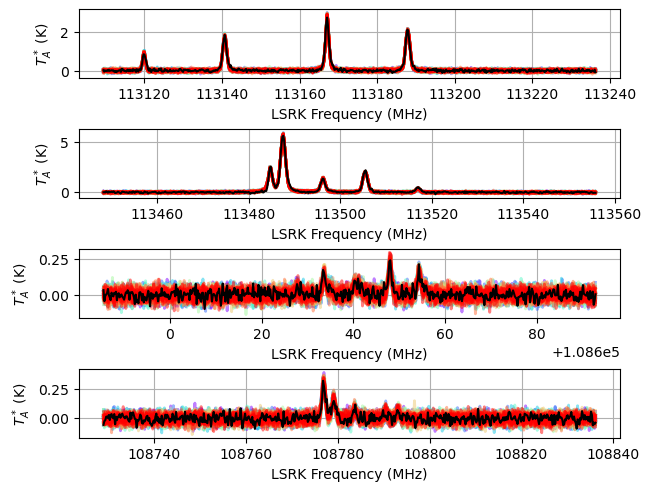

In [61]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [62]:
# 12C/13C ratio over all clouds
for solution in model.solutions:
    model.trace[f"solution_{solution}"]["ratio_12C_13C_total"] = (
        (10.0**model.trace[f"solution_{solution}"]["log10_N_12CN"]).sum(dim="cloud") / 
    model.trace[f"solution_{solution}"]["N_13CN"].sum(dim="cloud")
    )
    

In [63]:
pm.summary(model.trace.solution_0, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  55.025  11.711  32.317   76.001      0.154    0.109   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    5786.0    5947.0    1.0

In [65]:
import pickle
with open("/staging/twenger2/iram_trace.pkl", "wb") as f:
    pickle.dump(model.trace, f)

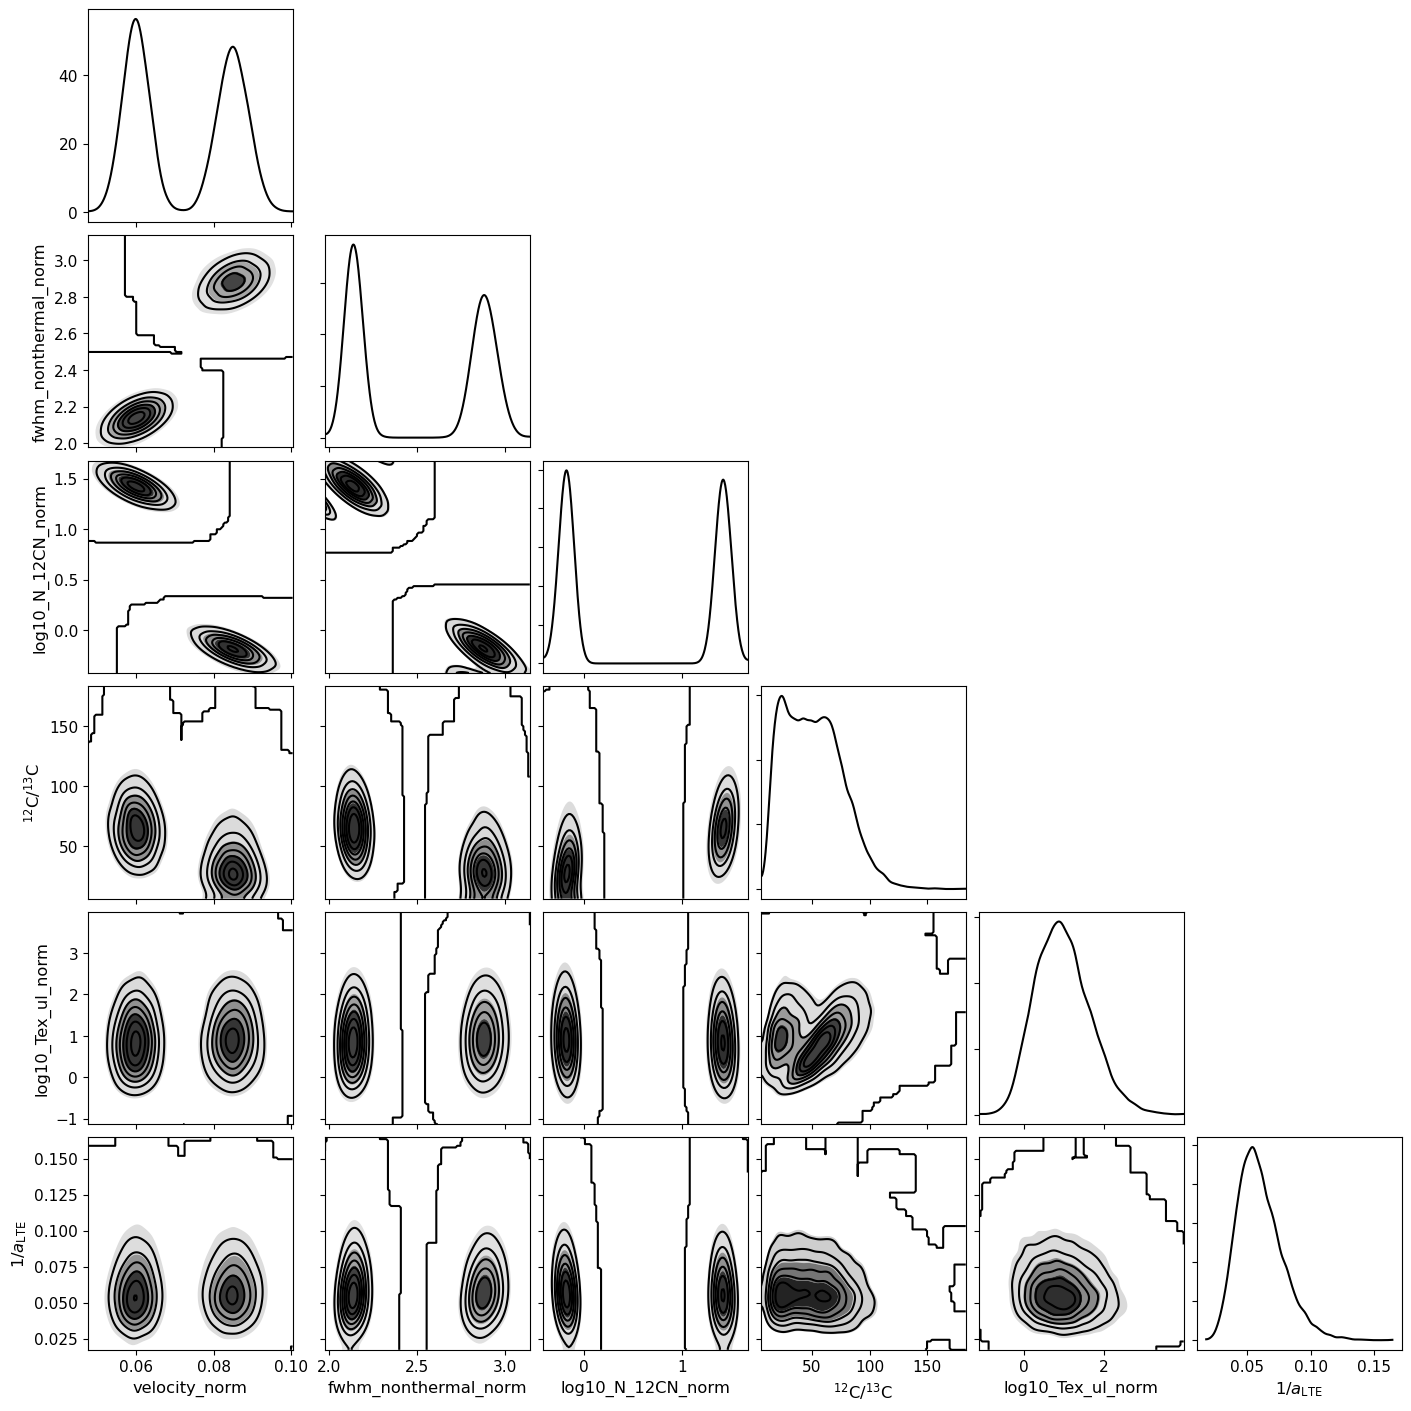

In [68]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

['velocity', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN', 'ratio_12C_13C']


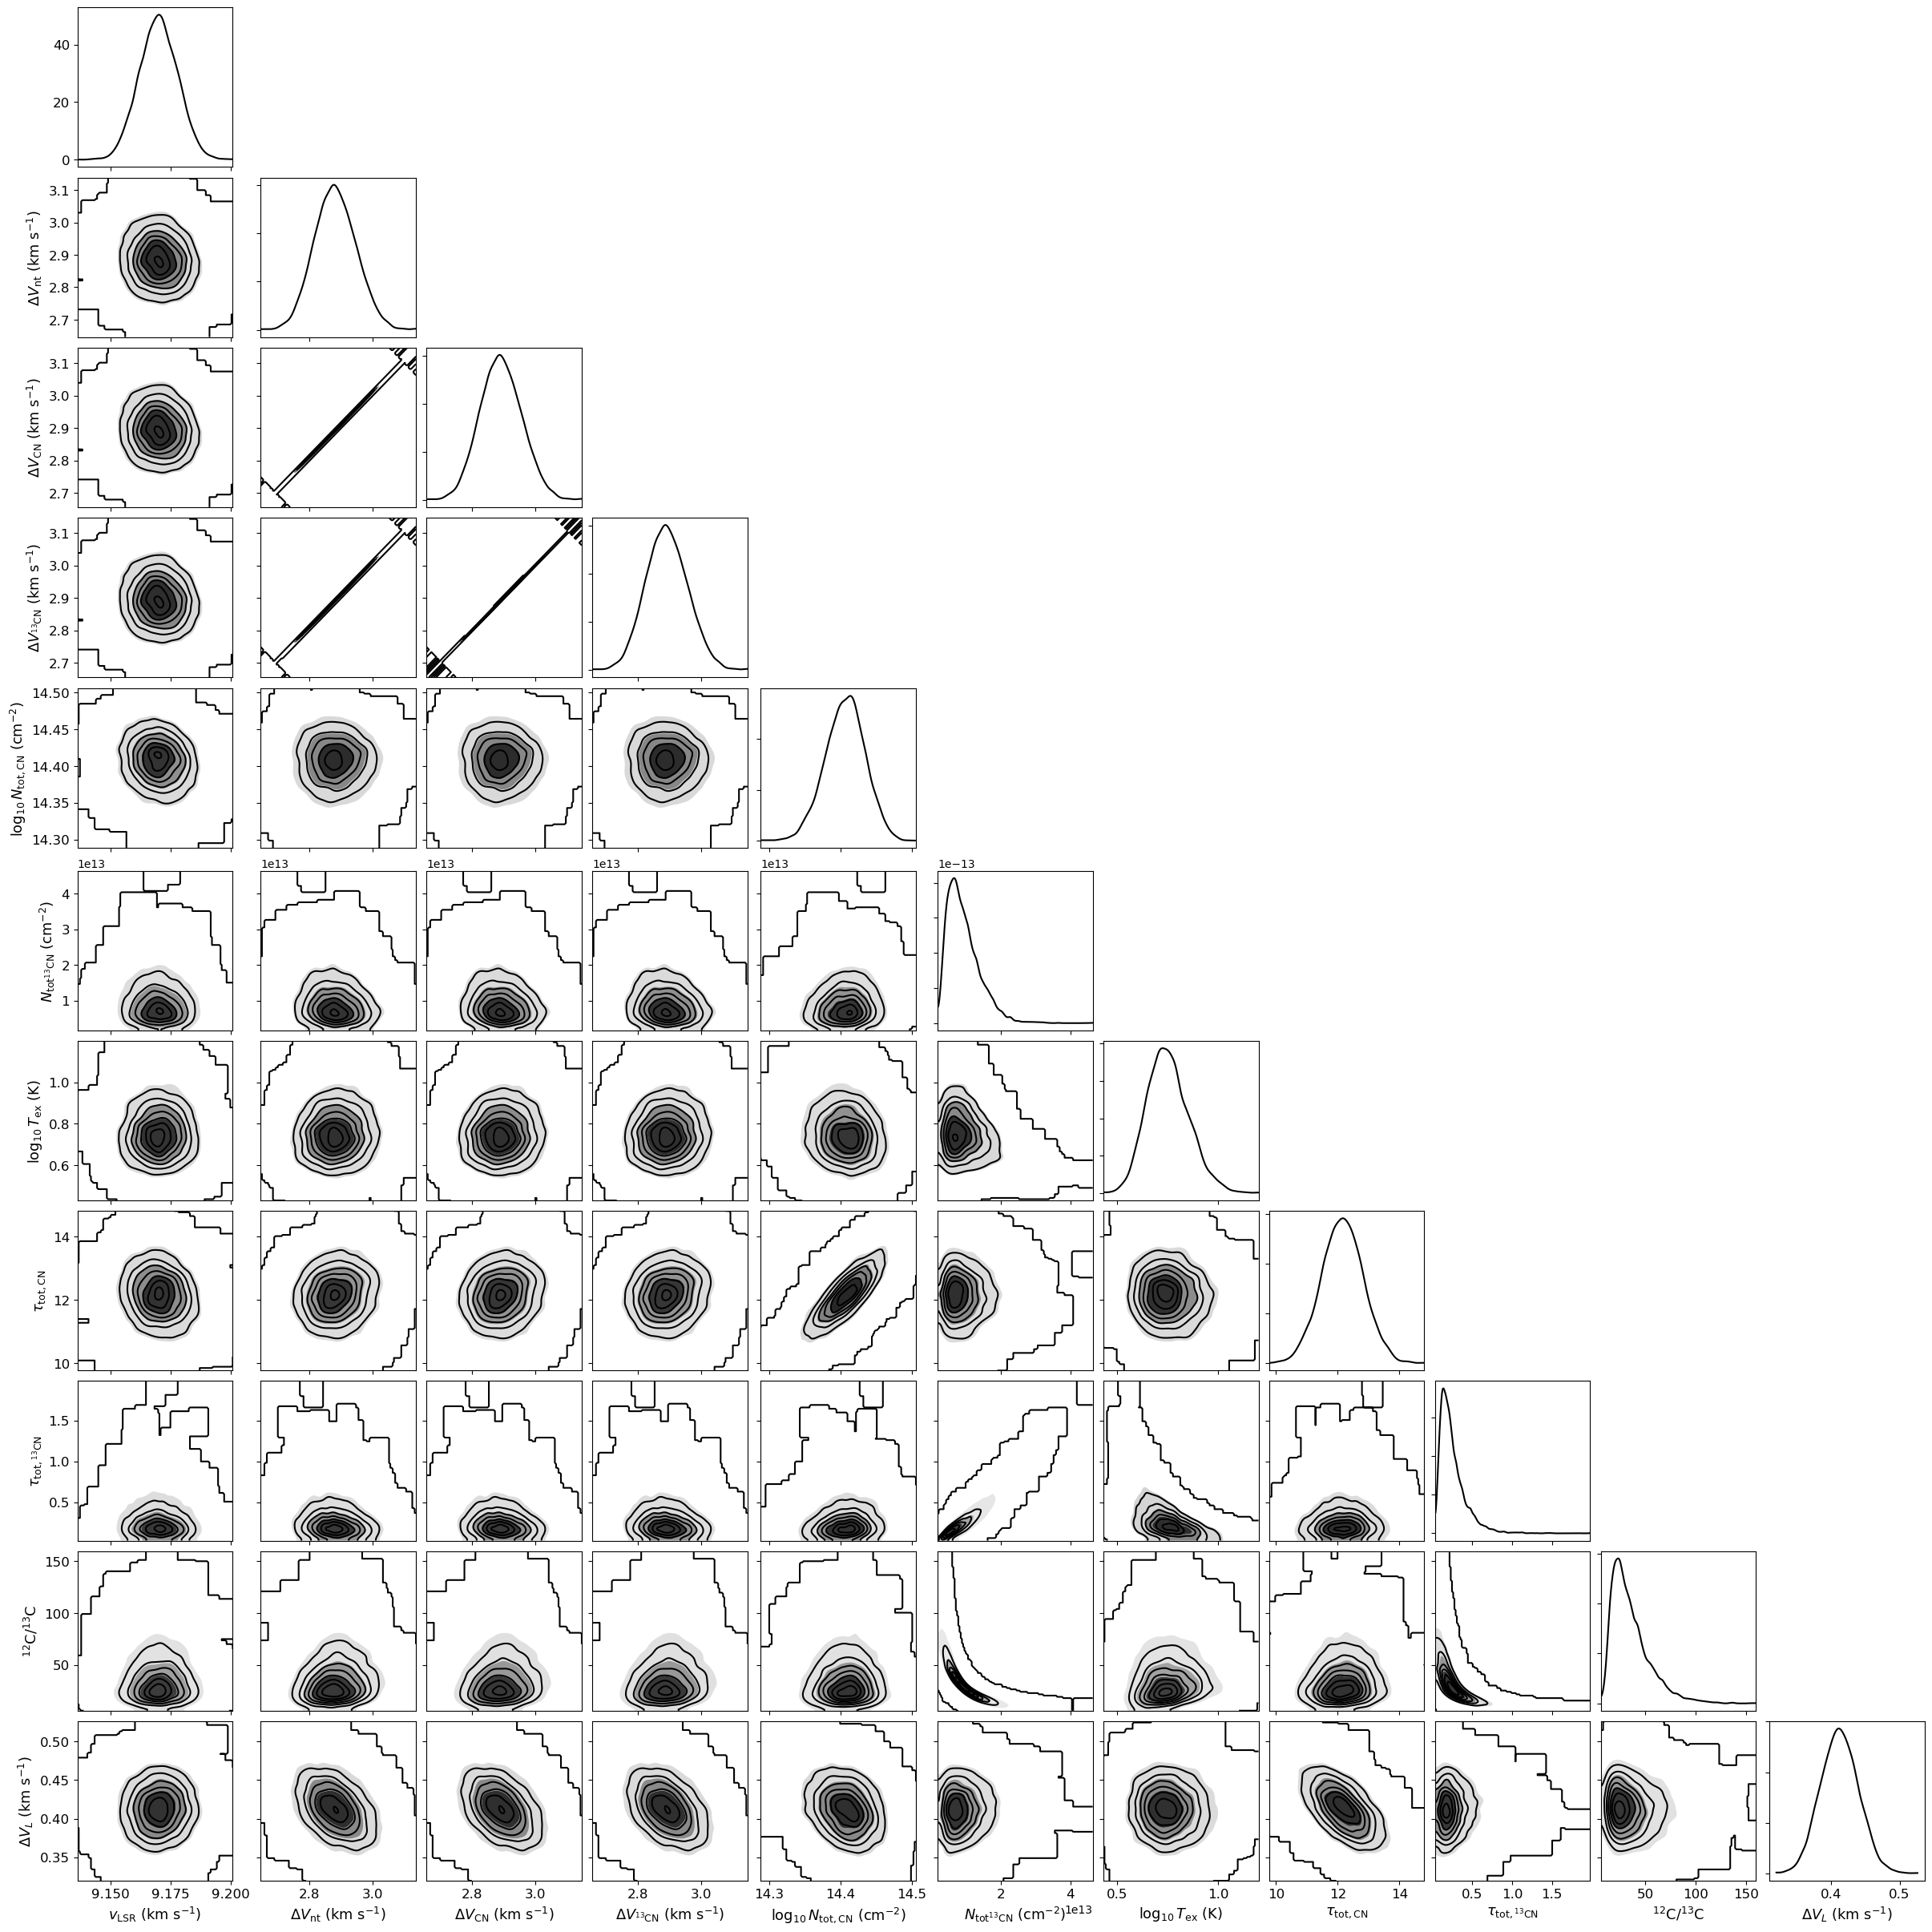

In [66]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics + ["ratio_12C_13C"]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    )) and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

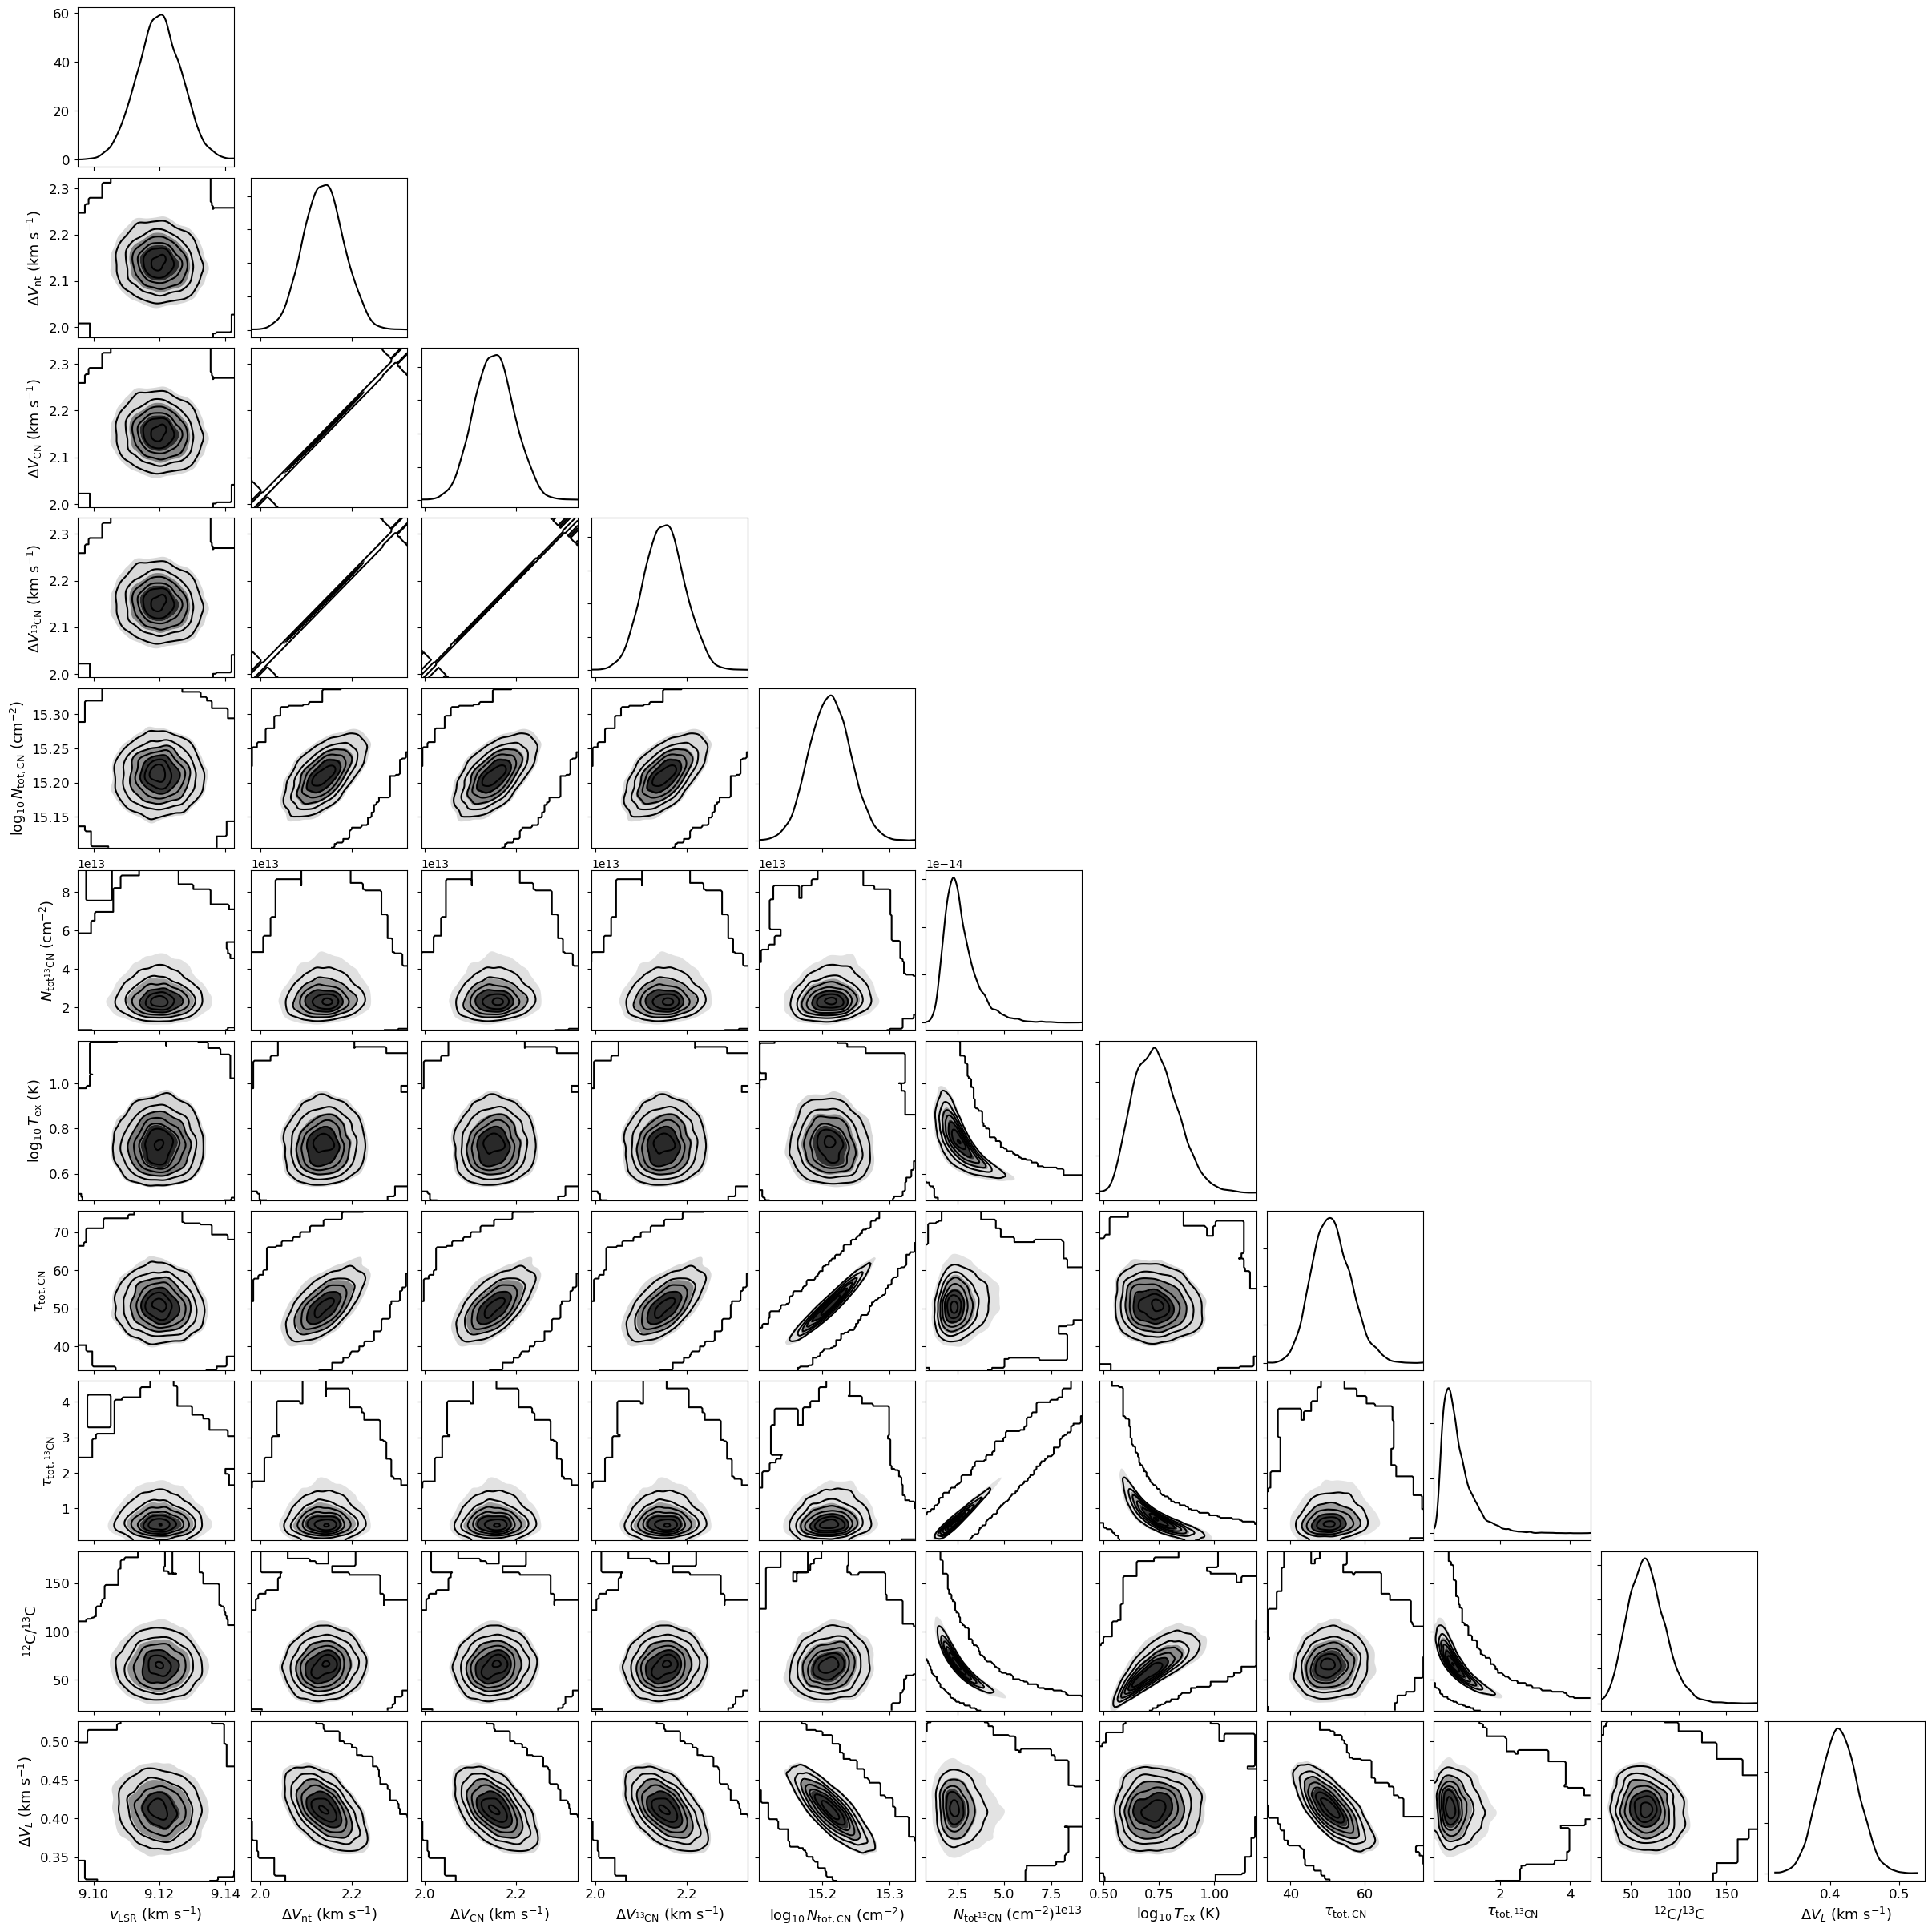

In [67]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [69]:
var_names = model.cloud_deterministics + model.baseline_freeRVs + model.hyper_freeRVs + model.hyper_deterministics + ["ratio_12C_13C", "ratio_12C_13C_total"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
display(point_stats)

mean            sd       hdi_16%  \
velocity[0]                9.170000e+00  8.000000e-03  9.162000e+00   
velocity[1]                9.120000e+00  7.000000e-03  9.113000e+00   
fwhm_thermal_12CN[0]       2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]       2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]       2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]       2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]         2.883000e+00  6.600000e-02  2.812000e+00   
fwhm_nonthermal[1]         2.139000e+00  4.500000e-02  2.090000e+00   
fwhm_12CN[0]               2.892000e+00  6.600000e-02  2.822000e+00   
fwhm_12CN[1]               2.152000e+00  4.400000e-02  2.103000e+00   
fwhm_13CN[0]               2.892000e+00  6.600000e-02  2.821000e+00   
fwhm_13CN[1]               2.152000e+00  4.400000e-02  2.102000e+00   
log10_N_12CN[0]            1.440600e+01  2.800000e-02  1.438200e+01   
log10_N_12CN[1]            1.521100e+01  3.100000e-02  1.518100e+01   
N_13CN[0]                  9.142236e+12  4.681825e+12  3.447981e+12   
N_13CN[1]                  2.684474e+13  9.107196e+12  1.677750e+13   
log10_Tex_ul[0]            7.510000e-01  1.040000e-01  6.380000e-01   
log10_Tex_ul[1]            7.400000e-01  1.000000e-01  6.220000e-01   
Tex_12CN[113123.3687, 0]   2.288000e+00  6.000000e-02  2.224000e+00   
Tex_12CN[113123.3687, 1]  -2.591000e+00  7.790000e-01 -3.130000e+00   
Tex_12CN[113144.19, 0]    -2.430700e+01  3.647050e+02 -2.038600e+01   
Tex_12CN[113144.19, 1]     3.144000e+00  1.150000e-01  3.030000e+00   
Tex_12CN[113170.535, 0]    2.078000e+00  6.800000e-02  2.002000e+00   
Tex_12CN[113170.535, 1]   -2.269000e+00  5.770000e-01 -2.699000e+00   
Tex_12CN[113191.325, 0]   -1.141400e+01  1.073108e+03 -5.440900e+01   
Tex_12CN[113191.325, 1]    3.728000e+00  9.800000e-02  3.630000e+00   
Tex_12CN[113488.142, 0]    2.227000e+00  6.900000e-02  2.153000e+00   
Tex_12CN[113488.142, 1]   -2.305000e+00  5.890000e-01 -2.744000e+00   
Tex_12CN[113490.985, 0]    7.182400e+02  6.679881e+04 -3.443200e+01   
Tex_12CN[113490.985, 1]    4.208000e+00  1.360000e-01  4.067000e+00   
Tex_12CN[113499.643, 0]    1.833000e+00  1.710000e-01  1.687000e+00   
Tex_12CN[113499.643, 1]   -2.477000e+00  6.880000e-01 -2.943000e+00   
Tex_12CN[113508.934, 0]   -9.778100e+01  6.652244e+03 -2.735200e+01   
Tex_12CN[113508.934, 1]    3.661000e+00  9.100000e-02  3.560000e+00   
Tex_12CN[113520.4215, 0]   8.740000e+01  1.196459e+04 -2.403300e+01   
Tex_12CN[113520.4215, 1]   3.324000e+00  1.040000e-01  3.215000e+00   
tau_12CN[113123.3687, 0]   4.480000e-01  2.300000e-02  4.240000e-01   
tau_12CN[113123.3687, 1]  -2.170000e-01  1.800000e-02 -2.380000e-01   
tau_12CN[113144.19, 0]    -1.210000e-01  6.600000e-02 -1.930000e-01   
tau_12CN[113144.19, 1]     9.444000e+00  9.110000e-01  8.515000e+00   
tau_12CN[113170.535, 0]    3.661000e+00  1.900000e-01  3.454000e+00   
tau_12CN[113170.535, 1]   -2.356000e+00  1.660000e-01 -2.524000e+00   
tau_12CN[113191.325, 0]   -5.100000e-02  7.600000e-02 -1.280000e-01   
tau_12CN[113191.325, 1]    1.117000e+01  1.047000e+00  1.011100e+01   
tau_12CN[113488.142, 0]    4.696000e+00  2.460000e-01  4.428000e+00   
tau_12CN[113488.142, 1]   -2.965000e+00  2.200000e-01 -3.185000e+00   
tau_12CN[113490.985, 0]   -2.390000e-01  1.510000e-01 -3.960000e-01   
tau_12CN[113490.985, 1]    2.815100e+01  2.658000e+00  2.553300e+01   
tau_12CN[113499.643, 0]    3.846000e+00  2.030000e-01  3.637000e+00   
tau_12CN[113499.643, 1]   -1.976000e+00  1.860000e-01 -2.168000e+00   
tau_12CN[113508.934, 0]   -9.300000e-02  6.100000e-02 -1.600000e-01   
tau_12CN[113508.934, 1]    8.709000e+00  8.010000e-01  7.915000e+00   
tau_12CN[113520.4215, 0]   6.000000e-03  1.100000e-02 -5.000000e-03   
tau_12CN[113520.4215, 1]   1.134000e+00  1.030000e-01  1.022000e+00   
tau_total_12CN[0]          1.215300e+01  6.750000e-01  1.151800e+01   
tau_total_12CN[1]          5.109300e+01  5.215000e+00  4.54

## Assumption about 13CN Excitation Temperature
There is no evidence for CTEX in the 13CN data, and we are unable to constrain the excitation temperature of 13CN because we only detect the brightest transitions. Here we relax the 13CN CTEX assumption and instead assume that it suffers from hyperfine anomalies the same as 12CN.

In [70]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.5, 0.5], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [9.0, 2.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.6, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = False, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1/2, 12CN-3/2, 13CN-1/2, 13CN-3/2, LTE_precision, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, baseline_13CN-1/2_norm, baseline_13CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN, weights_13CN]


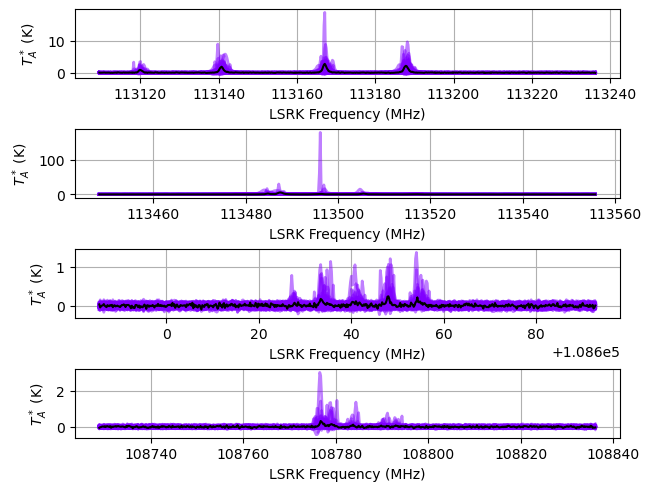

In [71]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [72]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7200
Interrupted at 7,199 [7%]: Average Loss = 5.2756e+19


Output()

Runtime: 2.75 minutes


Sampling: [12CN-1/2, 12CN-3/2, 13CN-1/2, 13CN-3/2]


Output()

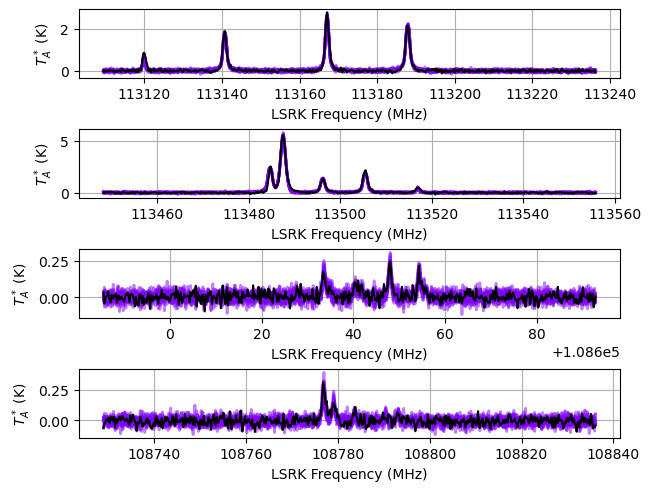

In [73]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [74]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7200
Interrupted at 7,199 [7%]: Average Loss = 5.2756e+19
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, baseline_13CN-1/2_norm, baseline_13CN-3/2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN, weights_13CN]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 20152 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
Runtime: 339.82 minutes


In [75]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [76]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1/2_norm[0] -2.160000e-01  4.200000e-02 -2.920000e-01   
baseline_12CN-3/2_norm[0] -4.490000e-01  4.800000e-02 -5.390000e-01   
baseline_13CN-1/2_norm[0] -1.010000e-01  4.500000e-02 -1.840000e-01   
baseline_13CN-3/2_norm[0] -1.160000e-01  4.500000e-02 -2.000000e-01   
velocity_norm[0]           8.500000e-02  4.000000e-03  7.700000e-02   
velocity_norm[1]           6.000000e-02  3.000000e-03  5.400000e-02   
log10_N_12CN_norm[0]      -1.940000e-01  5.700000e-02 -2.980000e-01   
log10_N_12CN_norm[1]       1.413000e+00  6.200000e-02  1.300000e+00   
log10_Tex_ul_norm[0]       1.248000e+00  7.140000e-01 -6.100000e-02   
log10_Tex_ul_norm[1]       1.681000e+00  6.760000e-01  4.380000e-01   
fwhm_nonthermal_norm[0]    2.872000e+00  6.600000e-02  2.749000e+00   
fwhm_nonthermal_norm[1]    2.125000e+00  4.500000e-02  2.038000e+00   
fwhm_L_norm                4.170000e-01  2.800000e-02  3.630000e-01   
ratio_12C_13C[0]           3.963300e+01  1.715100e+01  1.376200e+01   
ratio_12C_13C[1]           9.398400e+01  2.369700e+01  5.291800e+01   
LTE_precision[0]           5.600000e-02  1.600000e-02  2.800000e-02   
LTE_precision[1]           4.100000e-02  1.300000e-02  2.100000e-02   
weights_12CN[0, 0 0 1 1]   5.420000e-01  3.000000e-02  4.880000e-01   
weights_12CN[0, 0 0 1 2]   7.000000e-02  1.800000e-02  3.500000e-02   
weights_12CN[0, 1 0 1 1]   5.100000e-02  2.000000e-03  4.700000e-02   
weights_12CN[0, 1 0 1 2]   8.000000e-02  3.000000e-03  7.400000e-02   
weights_12CN[0, 1 0 2 1]   2.800000e-02  7.000000e-03  1.500000e-02   
weights_12CN[0, 1 0 2 2]   9.500000e-02  3.000000e-03  8.800000e-02   
weights_12CN[0, 1 0 2 3]   1.330000e-01  9.000000e-03  1.180000e-01   
weights_12CN[1, 0 0 1 1]   6.000000e-03  3.000000e-03  1.000000e-03   
weights_12CN[1, 0 0 1 2]   4.820000e-01  1.000000e-02  4.640000e-01   
weights_12CN[1, 1 0 1 1]   4.300000e-02  2.000000e-03  3.900000e-02   
weights_12CN[1, 1 0 1 2]   1.130000e-01  2.000000e-03  1.090000e-01   
weights_12CN[1, 1 0 2 1]   4.700000e-02  2.000000e-03  4.400000e-02   
weights_12CN[1, 1 0 2 2]   1.100000e-01  2.000000e-03  1.060000e-01   
weights_12CN[1, 1 0 2 3]   1.990000e-01  5.000000e-03  1.890000e-01   
weights_13CN[0, 0 1 0 1]   9.200000e-02  5.900000e-02  3.000000e-03   
weights_13CN[0, 0 1 1 0]   2.600000e-02  2.900000e-02  0.000000e+00   
weights_13CN[0, 0 1 1 1]   8.300000e-02  5.200000e-02  1.000000e-03   
weights_13CN[0, 0 1 1 2]   1.640000e-01  7.800000e-02  2.900000e-02   
weights_13CN[0, 1 1 0 1]   4.500000e-02  4.700000e-02  0.000000e+00   
weights_13CN[0, 1 1 1 0]   2.600000e-02  3.000000e-02  0.000000e+00   
weights_13CN[0, 1 1 1 1]   5.000000e-02  4.400000e-02  0.000000e+00   
weights_13CN[0, 1 1 1 2]   6.900000e-02  4.700000e-02  0.000000e+00   
weights_13CN[0, 1 2 1 0]   1.700000e-02  2.300000e-02  0.000000e+00   
weights_13CN[0, 1 2 1 1]   5.700000e-02  4.700000e-02  0.000000e+00   
weights_13CN[0, 1 2 1 2]   7.200000e-02  4.800000e-02  0.000000e+00   
weights_13CN[0, 1 2 2 1]   4.800000e-02  4.000000e-02  0.000000e+00   
weights_13CN[0, 1 2 2 2]   1.230000e-01  6.500000e-02  9.000000e-03   
weights_13CN[0, 1 2 2 3]   1.290000e-01  6.200000e-02  1.700000e-02   
weights_13CN[1, 0 1 0 1]   9.100000e-02  5.100000e-02  7.000000e-03   
weights_13CN[1, 0 1 1 0]   1.700000e-02  1.500000e-02  0.000000e+00   
weights_13CN[1, 0 1 1 1]   1.030000e-01  4.400000e-02  2.000000e-02   
weights_13CN[1, 0 1 1 2]   1.840000e-01  6.000000e-02  7.200000e-02   
weights_13CN[1, 1 1 0 1]   5.600000e-02  5.100000e-02  0.000000e+00   
weights_13CN[1, 1 1 1 0]   1.700000e-02  1.200000e-02  0.000000e+00   
weights_13CN[1, 1 1 1 1]   5.700000e-02  2.200000e-02  1.200000e-02   
weights_13CN[1, 1 1 1 2]   9.400000e-02  2.400000e-02  4.900000e-02   
weights_13CN[1, 1 2 1 0]   1.700000e-02  1.000000e-02  0.000000e+00   
weights_13CN[1, 1 2 1 1]   5.900000e-02  2.200000e-02  1.400000e-02   
weights_13CN[1, 1 2 1 2]   9.100000e-02  2.600000e-02  4.30

Sampling: [12CN-1/2, 12CN-3/2, 13CN-1/2, 13CN-3/2]


Output()

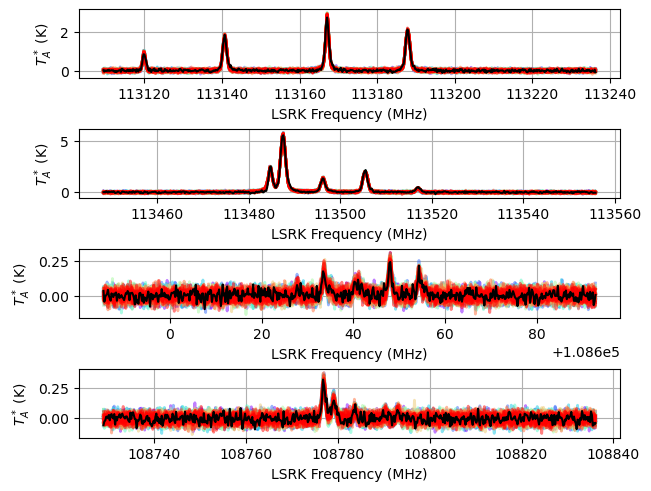

In [77]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [78]:
# 12C/13C ratio over all clouds
for solution in model.solutions:
    model.trace[f"solution_{solution}"]["ratio_12C_13C_total"] = (
        (10.0**model.trace[f"solution_{solution}"]["log10_N_12CN"]).sum(dim="cloud") / 
    model.trace[f"solution_{solution}"]["N_13CN"].sum(dim="cloud")
    )
    

In [79]:
pm.summary(model.trace.solution_0, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  75.153  14.838  49.964  105.047      0.215    0.152   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    4705.0    5642.0    1.0

In [80]:
import pickle
with open("/staging/twenger2/iram_trace_noCTEX.pkl", "wb") as f:
    pickle.dump(model.trace, f)